<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

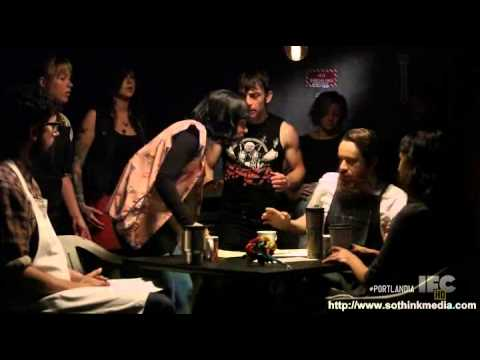

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'C:\\Users\\deepa\\Documents\\repo\\U4-S1-NLP\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [24]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [25]:
shops['coffee_shop_name'].value_counts().to_frame()

,coffee_shop_name
Epoch Coffee,400
Halcyon,300
The Factory - Cafe With a Soul,244
Houndstooth Coffee,200
Venezia Italian Gelato,200
...,...
Lucky Lab Coffee,25
Sister Coffee,17
Kowabunga Coffee,16
The Marvelous Vintage Tea Party Co.,10


In [26]:
shops['full_review_text'].value_counts().to_frame()

,full_review_text
10/28/2016 AMAZING atmosphere! I walked around for 5 minutes looking at everything before even ordering. Most unique take on chicken and waffles I've ever had. Hands down best night time hangout in North Austin. P.S.... their Matcha Latte is to die for!,4
"10/19/2016 The matcha lattes are amazing! Great atmosphere, great food and drink, and everything is plated beautifully. The kind of place where you can tell the employees take pride in their work. I'll definitely be back often.",4
"11/17/2016 1 check-in Listed in 2016 - The Third Time is a Charm! The Factory has A+ decor and a very innovative interactionless (tablet) ordering system. This allows you to look up what to get without feeling pressured by a barista staring at you waiting for you to order. The eclectic selection of tables, couches, and swings (?!) inside with a small kiddy corner appeal to many different types of tastes. This is seriously a cool place to hang out. However, when it comes to the coffee and food, it's rather not cheap. The waffles range from $4-$8, and coffee is between $3.50 and $5. The quality of the coffee is not yet up to par with other coffee mainstays in Austin, so I would probably not choose to come here just for coffee. However, it is a CUTE date place and I know that M and I will probably come back to chat, people-watch, or read books.",4
"10/25/2016 1 check-in Ok, let's try this approach... Pros: Music Seating Decor General ambiance Service Cons: iPad ordering (I'm a crotchety old man, kids) Limited coffee menu, or menu in general Relatively expensive Food is pretty but lackluster I'm still sitting here as I type this and I'm less than overjoyed with the experience, sadly. The space and vibe are great but not quite familiar or intimate enough to beat out a place like Genuine Joe down the street. It seems like they bank on the vibe, and fall short the rest of the way. (This would be a great hangout for the artsy/design crowd having a collaborative meeting.) The staff is great but the iPad ordering system limits your required interaction with them. They take pride in no wifi to increase interaction but then use iPads instead of people? Seating is ample, if cramped in a surprisingly large space. But the food, kids. So pretty, but again lackluster. I tried the Pop+art ($5) and the Nutella Waffle ($4.75) and they both sit on their respective tiny awkward plates half eaten. (Yes the plate liners are cute) The waffle is a great idea but the waffle itself has no flavor and there's no delight. The tart is similar - the pastry crust is much too thick compared to the Smuckers jam tasting filling and it is essentially just pure sugar. The pastry itself doesn't even taste buttery or crisp. Meh. There appears to be no soul in this confectionary. Coffee- passable. But at $4 for a cortado and a $1.50 up-charge for almond milk- I'll pick another place. I get why the reviews are so good here, but there are much better places nearby for that ""cafe with a soul"" feel. This feels like an ACL pop-up. Going for that? Great, come here. Pop+art and Cortado Emailed receipt and satisfaction survey. See all photos from Kimberlee A. for The Factory - Cafe With a Soul",4
"11/9/2016 1 check-in Guys, this place is amazing. Limited food menu but both waffle offerings will blow you away! Crazy good spices on the chicken. The coffee and matcha were both stellar as well. Service was friendly and efficient. The space is stunning and cozy. Highly recommend. Will be my new go-to relaxation spot in the area.",4
...,...
"3/6/2016 2 check-ins Listed in ""Nuptial Coffee Bliss!"", Domainatrix This north Austin Domain complex just gets bigger & better. If I were young & foolish again or temporarily deluded by male menopause, I'd get a very cool dog and move here in a flash. In the meantime, Two Hands and $2.49 will get you a good cup of coffee. If I were a resident I'd give this place five stars and move on. But since I'm not, I'll tell you parking around here can b

In [27]:
#Stip away the dates
import re
dates = []
for text in shops['full_review_text']:
    dates.append(re.findall(r'\b[0-3]?[0-9]/[0-3]?[0-9]/(?:[0-9]{2})?[0-9]{2}\b', text)[0])
shops['review_date'] = dates

In [28]:
shops['review_date'].value_counts()

10/9/2016     31
9/18/2016     30
11/20/2016    27
11/2/2016     27
12/4/2016     26
              ..
4/22/2010      1
4/21/2014      1
1/21/2012      1
4/7/2014       1
4/19/2011      1
Name: review_date, Length: 1592, dtype: int64

In [29]:
shops['full_review_text']=shops['full_review_text'].astype(str)

In [30]:
#Remove date
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: " ". join(x.split()[1:]))
# extract checkin 
shops['full_review_text'] = shops['full_review_text'].str.replace(r"(\d+ check-ins?)", "")

shops['coffee_shop_name'] = shops['coffee_shop_name'].str.lower().str.strip()
shops['full_review_text'] = shops['full_review_text'].str.lower().str.strip()

In [31]:
shops.sample(10)

,coffee_shop_name,full_review_text,star_rating,review_date
2171,flat track coffee,great for people watching. had a delicious dec...,4.0 star rating,11/27/2016
1730,fat cats organic coffee and dessert,"at long last, a coffee shop in my neighborhood...",5.0 star rating,8/15/2015
6630,juan pelota,"you might get what you ordered, you might get ...",2.0 star rating,11/2/2014
5426,cuvée coffee bar,good coffee but way over priced. the employees...,1.0 star rating,12/29/2015
4787,venezia italian gelato,updated review still just as good as the firs...,5.0 star rating,7/19/2016
3323,jo’s coffee,mmmm i love this place! usually pretty friendl...,5.0 star rating,5/10/2016
3662,cenote,awesome sandwiches. great coffee. this place i...,5.0 star rating,1/17/2016
6808,teo,amazing does not do this place justice. their ...,5.0 star rating,12/20/2014
5365,cuvée coffee bar,stopped by cuvée out of curiosity as well as c...,1.0 star rating,7/1/2016
4880,the buzz mill,"not the worlds greatest coffee, but the infuse...",4.0 star rating,8/22/2016


### Star_Rating

In [32]:
shops['star_rating'].value_counts()

 5.0 star rating     3780
 4.0 star rating     2360
 3.0 star rating      738
 2.0 star rating      460
 1.0 star rating      278
Name: star_rating, dtype: int64

In [33]:
#remove star rating text from columns
shops['star_rating'] = shops['star_rating'].str.replace('star rating', '')

In [34]:
shops.sample(10)

,coffee_shop_name,full_review_text,star_rating,review_date
6398,"strange brew, austin coffee",strange brew used to be a pretty cool place to...,2.0,8/10/2016
427,summermoon coffee bar,love love love this place. not only is the cof...,5.0,8/24/2016
1922,epoch coffee,easily my favorite coffee shop in the entire c...,2.0,8/8/2016
502,monkey nest coffee,it seems to be almost impossible to find a lat...,2.0,5/31/2016
3364,jo’s coffee,got the belgium bomber and turbo. i like the l...,4.0,6/5/2016
4529,sorrento’s coffee,"great coffee, great service. it is a drive thr...",5.0,8/9/2016
4822,venezia italian gelato,yum!! and the owners are from italy!!!! cute s...,5.0,6/14/2016
965,venezia italian gelato,as someone lucky enough to have lived in italy...,5.0,5/25/2016
6584,juan pelota,cute location with a bike shop within good smo...,4.0,2/13/2016
1526,figure 8 coffee purveyors,"been here twice in two days. nice space, but t...",2.0,3/15/2016


### Processing the row text with spacy

In [35]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

In [37]:
def lemmatize_txt(text):
    lemmas = [] # Store lemmas
    doc = nlp(text) # Instantiate doc object
    # Loop through each token in text
    for token in doc:
        if token.lemma_:
            if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
                lemmas.append(token.lemma_)
    return ' '.join(lemmas)
shops['lemmatize_full_review_text'] = shops['full_review_text'].apply(lemmatize_txt)
shops['lemmatize_full_review_text'] = shops['lemmatize_full_review_text'].str.strip()
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,lemmatize_full_review_text
0,the factory - cafe with a soul,love love loved the atmosphere! every corner o...,5.0,11/25/2016,love love love atmosphere corner coffee shop s...
1,the factory - cafe with a soul,"listed in date night: austin, ambiance in aust...",4.0,12/2/2016,list date night austin ambiance austin beautif...
2,the factory - cafe with a soul,listed in brunch spots i loved the eclectic an...,4.0,11/30/2016,list brunch spot love eclectic homey plush dec...
3,the factory - cafe with a soul,very cool decor! good drinks nice seating howe...,2.0,11/25/2016,cool decor good drink nice seating overpriced ...
4,the factory - cafe with a soul,they are located within the northcross mall sh...,4.0,12/3/2016,locate northcross mall shopping center face ea...


In [40]:
shops['lemmatize_full_review_text'].value_counts().to_frame()

,lemmatize_full_review_text
enthusiastic earnest desire excellent try new thing develop new menu idea smile face good almond pound cake worth 5 star fantastic cup red rooibos ice tea hanabi fantastic new spot,4
guy place amazing limited food menu waffle offering blow away crazy good spice chicken coffee matcha stellar service friendly efficient space stunning cozy highly recommend new relaxation spot area,4
try new cafe spot burnet friend unassuming storefront decor quaint af order ipad counter choose place sit brunch spot think cafe couple food option nutella waffles get point chicken option cold brew coffee fantastic friend milk tea turn great good spot conversation knock star limited option hope add item menu milk tea humongous nutella banana waffles love illustration photo ramya b. factory cafe soul,4
check factory past sunday husband want try delicious looking waffle definitely disappointed husband order iced coffee drink delicious good golden age milk tea worth 10 minute wait tea steep order nutella waffle perfect wood plate amazing paper liner print famous person inspirational quote want paper cute waffle basically half waffle spread nutella layer banana fold half small perfect banana balance sweetness nutella waffle crisp perfection provide crunch meal menu limited nutella waffle fry chicken waffle hope eventually serve waffle totally respect decision start small space gorgeous swing mural bar look meticulously plan big advice come place kid way seating set large people definitely place high chair giant magnetic poetry column crazy chair outside couple table game giant chess set look risky grabby kid behave child handle think fine watch family come leave order comment good space bother love kidless space jarring expect brunch family excited regular great new spot,4
list search fantastic coffee want write review want tell awesome factory cafe soul want overrun super busy place sit like decent coffee shop austin happen come friend mid week sit hour enjoy peace quiet atmosphere awesome coffee place little eclectic lot peculiar art book game knick knack head scratch drink food menu waffles pop tart beer coffee mojito work go work fabulously serve stumptown coffee northwest totally appreciate brew coffee correctly hint bitterness overcooked milk go ipad order screen cool need option customization million different type seating couch pillow swing big chair little chair bar seating regular table delightful refreshing barista foam art see houndstooth austin hang wonderful experience star establishment good coffee house austin time time double espresso tonic water beautiful macha beary lovely mocha,4
...,...
let stress people talk coffee shop bakery coffee shop coffee good hint order cappuccino ask want 12 ounce 16 ounce 20 ounce cup coffee come automate machine find starbucks bakery stuff excellent coffee heck epic monkey nest excellent coffee serve russell bakery,1
3 3.5 star cute spot downtown area pick coffee cashier person make french press drip coffee barista espresso base drink line slowly time get standard french press coffee large $ 3.10 yelp.com/user_local_phot good good coffee think well experience order espresso base drink and/or breakfast taco and/or hang spacious inside modern come area coffee prefer boutique roastery parking area tough lot street parking downtown area french press coffee large $ 3.10,1
fast service quick bite great pressed sandwich fresh flavor lot variety cool drink friendly helpful staff,1
place awesome open 24/7 plus come final second affordable coffee taste good love mocha drink name popular book example pride prejudice moby dick scarlet letter regular house brew coffee taste great drink order regular hot latte regular ice coffee hazel nut syrup interior design atmosphere perfect chill hangout casual date study bunch table seat time get packed kind fight seat smoke love nature outdoor seating cute light hang outside overall love place definitely recommend acai smoothie peach pear apricot smoo

In [42]:
STOPWORDS = nlp.Defaults.stop_words.union([' ','coffee', "i've", "it's","i'm",'-','-PRON-'])

def tokenize_text(text):
    tokens = []
    doc = nlp(text) # Instantiate doc object
    """Add tokens w/o Stop Words"""
    for token in doc:
        if token.text not in STOPWORDS:
            tokens.append(token.text)
    return tokens

shops['tokens'] = shops['lemmatize_full_review_text'].apply(tokenize_text)
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_date,lemmatize_full_review_text,tokens
0,the factory - cafe with a soul,love love loved the atmosphere! every corner o...,5.0,11/25/2016,love love love atmosphere corner coffee shop s...,"[love, love, love, atmosphere, corner, shop, s..."
1,the factory - cafe with a soul,"listed in date night: austin, ambiance in aust...",4.0,12/2/2016,list date night austin ambiance austin beautif...,"[list, date, night, austin, ambiance, austin, ..."
2,the factory - cafe with a soul,listed in brunch spots i loved the eclectic an...,4.0,11/30/2016,list brunch spot love eclectic homey plush dec...,"[list, brunch, spot, love, eclectic, homey, pl..."
3,the factory - cafe with a soul,very cool decor! good drinks nice seating howe...,2.0,11/25/2016,cool decor good drink nice seating overpriced ...,"[cool, decor, good, drink, nice, seating, over..."
4,the factory - cafe with a soul,they are located within the northcross mall sh...,4.0,12/3/2016,locate northcross mall shopping center face ea...,"[locate, northcross, mall, shopping, center, f..."


In [43]:
from collections import Counter
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [44]:
# Use the Function
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
74,place,3892,6060,1.0,0.018061,0.018061,0.511029
139,good,3606,5421,2.0,0.016157,0.034218,0.473477
56,great,2860,3959,3.0,0.011799,0.046017,0.375525
154,like,2274,3380,4.0,0.010074,0.056091,0.298582
428,come,1935,2642,5.0,0.007874,0.063965,0.254070


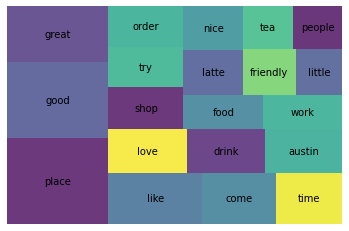

In [45]:
import squarify
import matplotlib.pyplot as plt

#Top 20 word
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [49]:
shops['star_rating']= shops['star_rating'].astype('float')

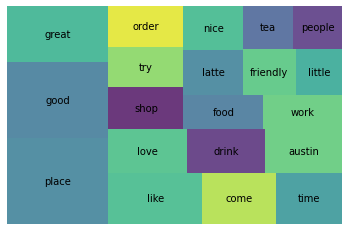

In [59]:

wc_bad=  count(shops[shops['star_rating'] < 4]['tokens'])
wc_bad_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_bad_top20['pct_total'], label=wc_bad_top20['word'], alpha=0.8)
plt.axis('off')
plt.show()

### Good_word Count

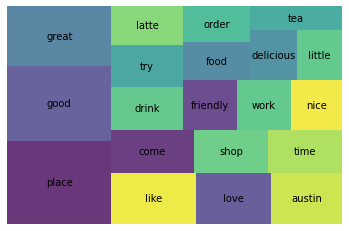

In [60]:
wc_good = count(shops[shops['star_rating'] >= 4]['tokens'])
wc_top20_good = wc_good[wc_good['rank'] <= 20]

squarify.plot(sizes=wc_top20_good['pct_total'], label=wc_top20_good['word'], alpha=0.8)
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [63]:
wc_bad['appears_in_pct_bad'] = wc_bad['appears_in_pct']
diff = wc_good[['word', 'appears_in_pct']].merge(wc_bad[['word', 'appears_in_pct_bad']], how='outer')
diff.head(20)

,word,appears_in_pct,appears_in_pct_bad
0,place,0.510749,0.512195
1,good,0.481596,0.439702
2,great,0.409121,0.235772
3,like,0.273290,0.403794
4,love,0.262704,0.141599
5,austin,0.258306,0.170732
6,come,0.241531,0.306233
7,shop,0.219870,0.216125
8,time,0.218567,0.287940
9,drink,0.207818,0.245257


In [64]:
diff['diff'] = diff['appears_in_pct'] - diff['appears_in_pct_bad']
diff.sort_values(by='diff').head(20)

,word,appears_in_pct,appears_in_pct_bad,diff
3,like,0.273290,0.403794,-0.130504
16,order,0.165472,0.293360,-0.127888
135,ask,0.050651,0.149051,-0.098400
29,service,0.141042,0.235095,-0.094053
197,bad,0.038111,0.132114,-0.094003
44,taste,0.106678,0.191057,-0.084379
83,$,0.064169,0.147696,-0.083527
154,customer,0.044951,0.126016,-0.081065
247,maybe,0.030945,0.105014,-0.074069
86,review,0.077687,0.151084,-0.073397


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

